In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
import os


 # Rainfall Prediction: Preprocessing and Feature Engineering

 ## Loading the datasets

In [40]:
train_path = os.path.join('data', 'train.csv')
test_path = os.path.join('data', 'test.csv')
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")


Train data shape: (2190, 13)
Test data shape: (730, 12)


 ## Data Inspection

In [41]:
print("Train data sample:")
train.head()


Train data sample:


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [42]:
print("Test data sample:")
test.head()


Test data sample:


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


 ## 1. Basic Preprocessing

 ### 1.1 Handling Missing Values

 Based on the EDA, we identified only one missing value in the 'winddirection' column of the test dataset.

In [43]:
# Check for missing values
print("Missing values in train data:")
print(train.isnull().sum())

print("\nMissing values in test data:")
print(test.isnull().sum())


Missing values in train data:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

Missing values in test data:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64


In [44]:
# Impute the missing value in the test dataset
# Using median for 'winddirection' since it's cyclical
test['winddirection'].fillna(test['winddirection'].median(), inplace=True)

# Verify missing values are handled
print("\nMissing values in test data after imputation:")
print(test.isnull().sum())



Missing values in test data after imputation:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
dtype: int64


 ### 1.2 Removing Unnecessary Features

 The 'id' column is just an identifier and has no predictive value.

In [45]:
# Remove 'id' column from both datasets
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

print("Train columns after removing 'id':", train.columns.tolist())
print("Test columns after removing 'id':", test.columns.tolist())


Train columns after removing 'id': ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall']
Test columns after removing 'id': ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


 ## 2. Outlier Detection and Handling



 From our EDA, we identified potential outliers in several features using box plots, histograms, and advanced methods like Isolation Forest and LOF. We'll use Isolation Forest to identify outliers and handle them appropriately.

 ### 2.1 Visualize Key Features Before Handling Outliers

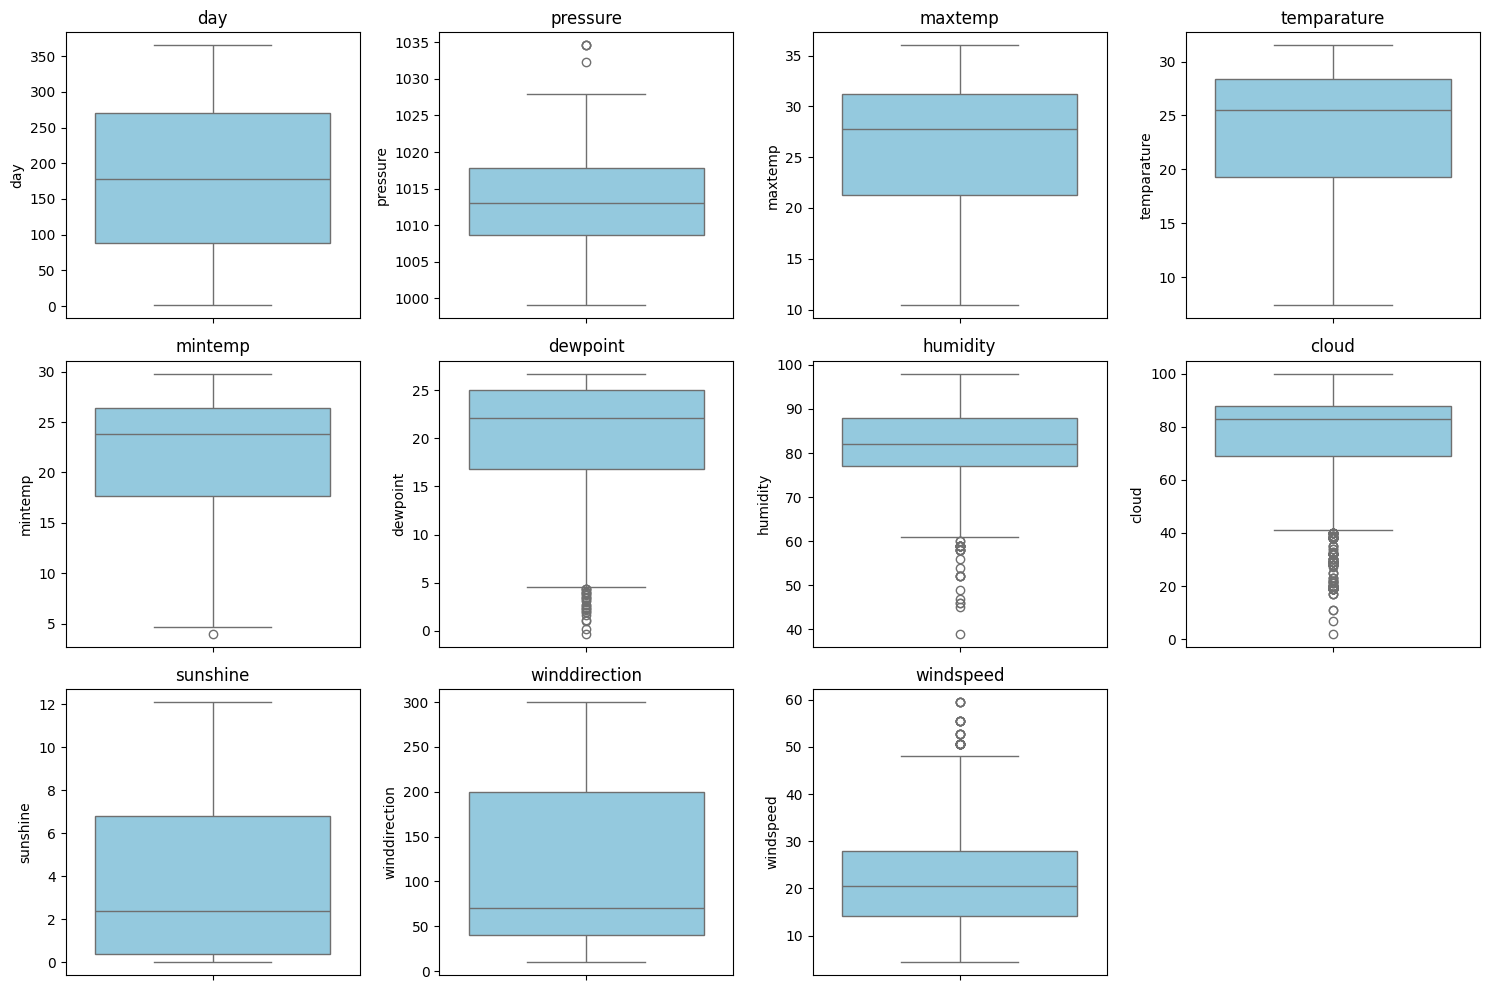

In [46]:
# Select numerical features (excluding target variable)
numerical_features = train.drop('rainfall', axis=1).select_dtypes(include=np.number).columns

# Create a grid of boxplots for key features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(data=train[feature], color='skyblue')
    plt.title(f"{feature}")
    plt.tight_layout()
plt.show()


 ### 2.2 Identify Outliers with Isolation Forest

In [47]:
# Create a copy to avoid modifying the original DataFrames
train_processed = train.copy()
test_processed = test.copy()

# Features to consider for outlier detection (excluding cyclical features)
outlier_features = [col for col in numerical_features if col not in ['day', 'winddirection']]

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit on train data (excluding target)
outlier_labels = iso_forest.fit_predict(train[outlier_features])

# Create a mask for outliers (-1 indicates an outlier)
outlier_mask = outlier_labels == -1

# Count the number of outliers detected
num_outliers = np.sum(outlier_mask)
print(f"Number of outliers detected: {num_outliers} ({num_outliers/len(train)*100:.2f}% of train data)")


Number of outliers detected: 110 (5.02% of train data)


 ### 2.3 Examine Outliers

Outlier statistics:
              day     pressure     maxtemp  temparature     mintemp  \
count  110.000000   110.000000  110.000000   110.000000  110.000000   
mean    77.900000  1021.391818   18.700909    16.130000   14.061818   
std    108.893092     5.949283    5.678682     5.198739    5.004731   
min      3.000000   999.000000   10.400000     7.400000    4.700000   
25%     15.000000  1020.600000   15.300000    13.125000   11.200000   
50%     22.500000  1022.700000   17.450000    15.200000   13.050000   
75%     68.750000  1024.400000   20.450000    18.100000   15.400000   
max    346.000000  1034.600000   35.400000    31.500000   28.700000   

         dewpoint    humidity       cloud    sunshine  winddirection  \
count  110.000000  110.000000  110.000000  110.000000     110.000000   
mean    10.278182   70.254545   52.100000    6.295455      48.727273   
std      6.214313   10.896036   28.375254    4.227268      53.141823   
min     -0.300000   39.000000    2.000000    0.00000

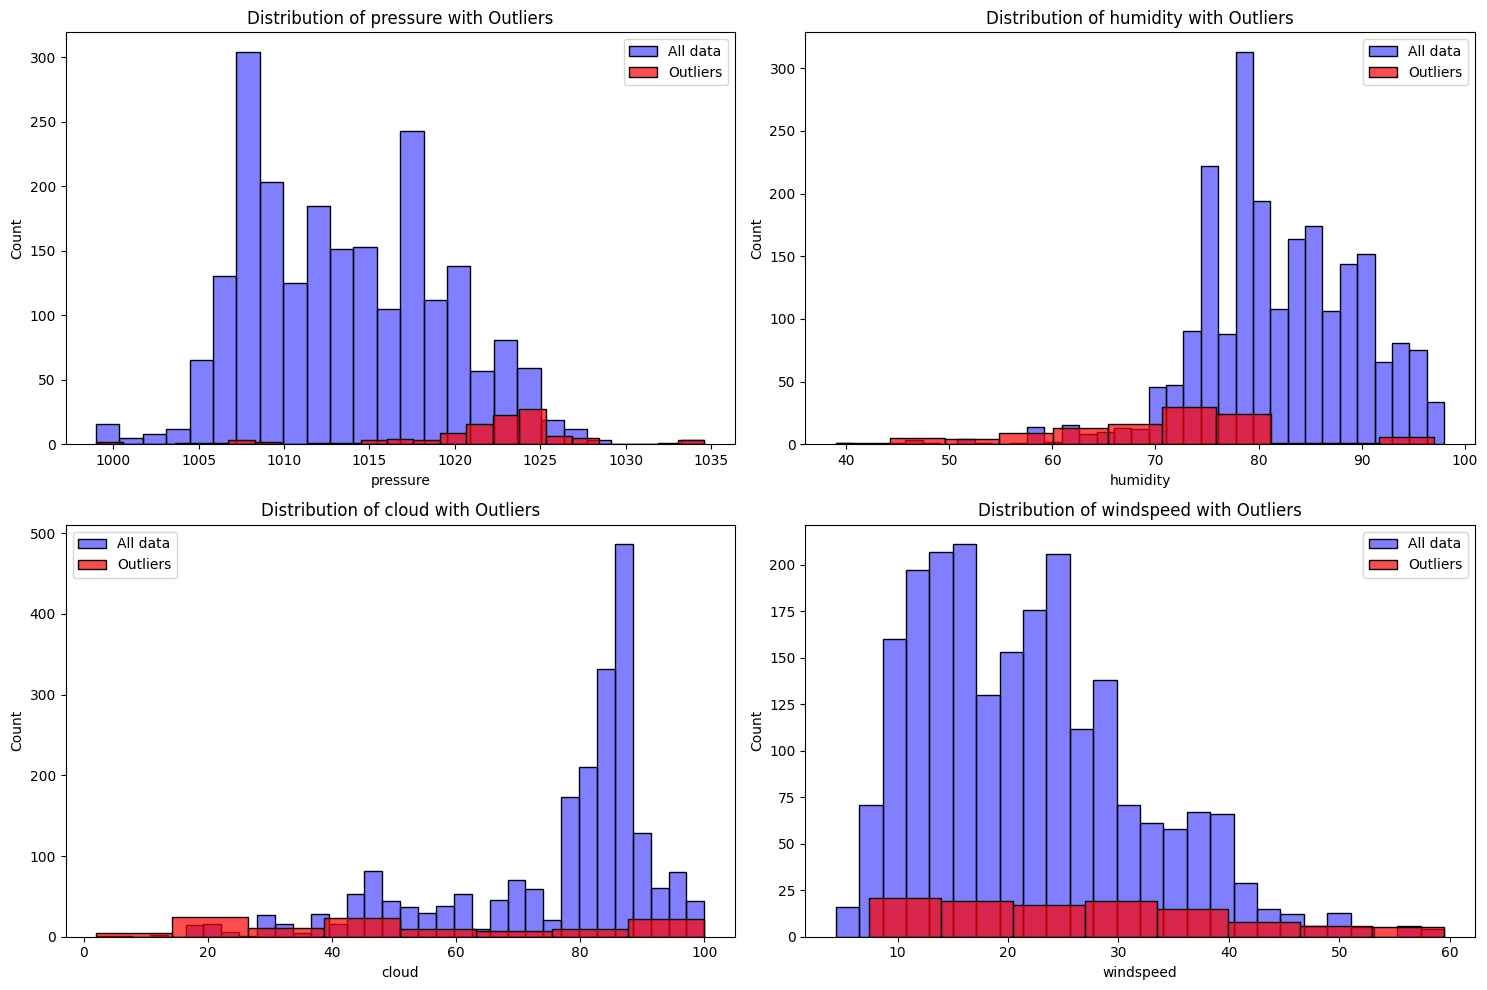

In [48]:
# Display outlier statistics
outliers = train[outlier_mask]
print("Outlier statistics:")
print(outliers.describe())

# Plot distribution of outliers for a few key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
features_to_plot = ['pressure', 'humidity', 'cloud', 'windspeed']

for i, feature in enumerate(features_to_plot):
    ax = axes[i//2, i%2]
    sns.histplot(train[feature], color='blue', alpha=0.5, ax=ax, label='All data')
    sns.histplot(outliers[feature], color='red', alpha=0.7, ax=ax, label='Outliers')
    ax.set_title(f'Distribution of {feature} with Outliers')
    ax.legend()

plt.tight_layout()
plt.show()


 ### 2.4 Handle Outliers



 Based on our EDA, we'll use a capping approach for extreme outliers while preserving the overall data distribution.

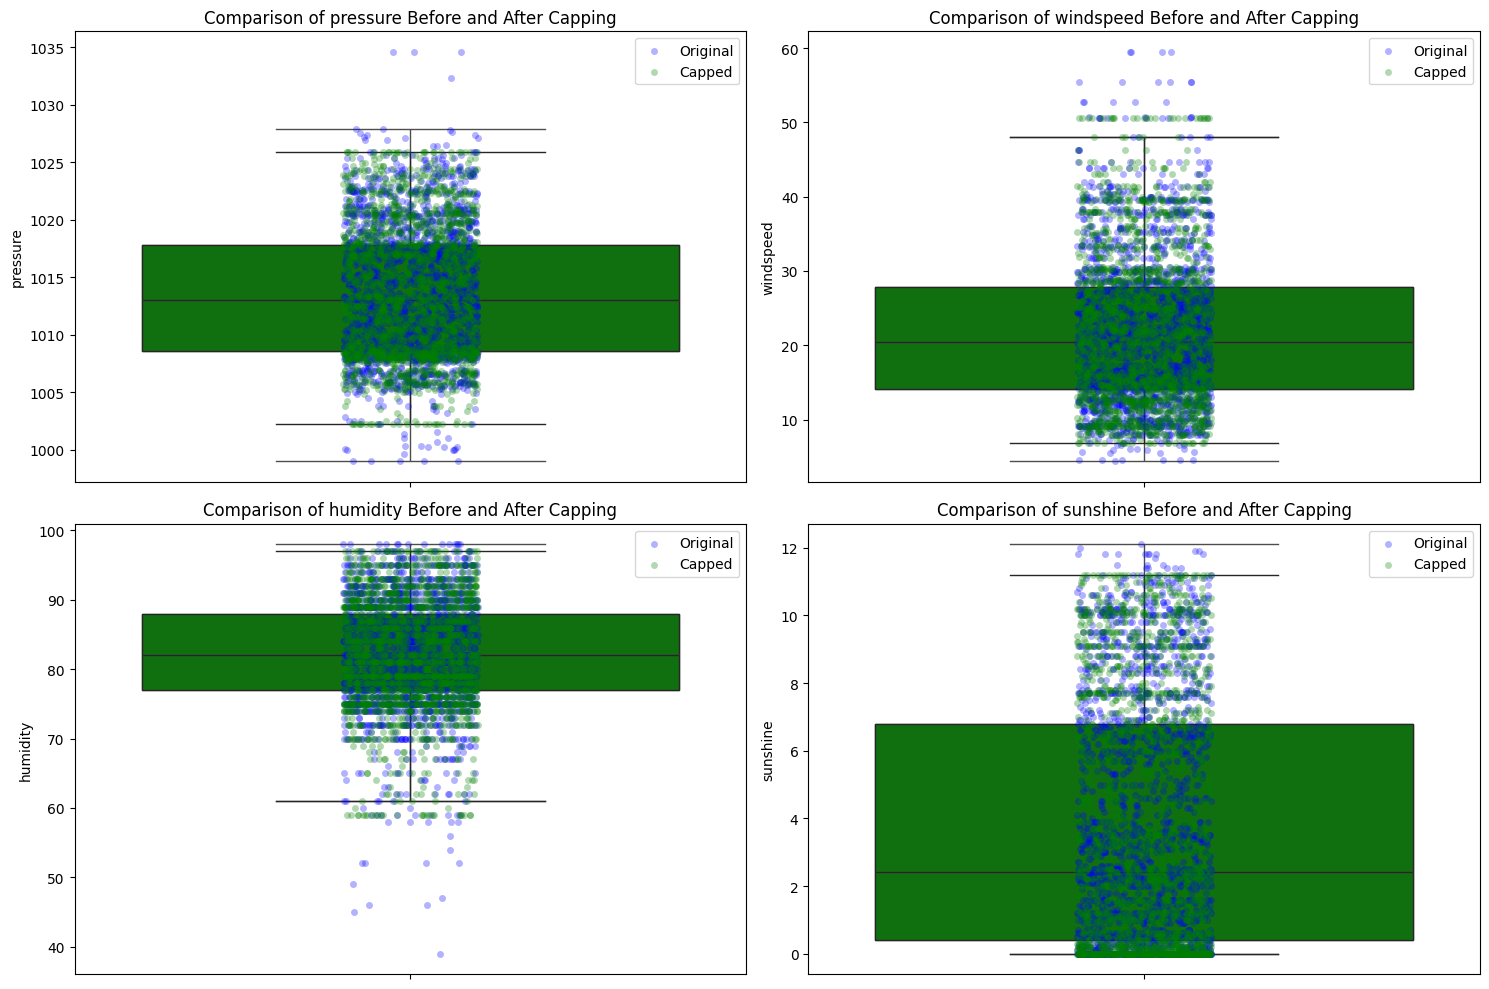

In [49]:
# Define a function to cap outliers at specified percentiles
def cap_outliers(df, features, lower_percentile=0.01, upper_percentile=0.99):
    df_capped = df.copy()
    for feature in features:
        # Get percentile values
        lower_limit = df[feature].quantile(lower_percentile)
        upper_limit = df[feature].quantile(upper_percentile)
        
        # Cap values
        df_capped[feature] = df_capped[feature].clip(lower=lower_limit, upper=upper_limit)
    
    return df_capped

# Cap outliers in train and test datasets
train_processed = cap_outliers(train_processed, outlier_features)
test_processed = cap_outliers(test_processed, outlier_features)

# Compare before and after for key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
features_to_compare = ['pressure', 'windspeed', 'humidity', 'sunshine']

for i, feature in enumerate(features_to_compare):
    ax = axes[i//2, i%2]
    sns.boxplot(data=train[feature], color='blue', ax=ax, showfliers=False)
    sns.stripplot(data=train[feature], color='blue', alpha=0.3, ax=ax, label='Original')
    
    sns.boxplot(data=train_processed[feature], color='green', ax=ax, showfliers=False)
    sns.stripplot(data=train_processed[feature], color='green', alpha=0.3, ax=ax, label='Capped')
    
    ax.set_title(f'Comparison of {feature} Before and After Capping')
    ax.legend()

plt.tight_layout()
plt.show()


 ## 3. Feature Engineering

 ### 3.1 Handle Cyclical Features



 The 'day' and 'winddirection' are cyclical features and should be encoded accordingly using sine and cosine transformations.

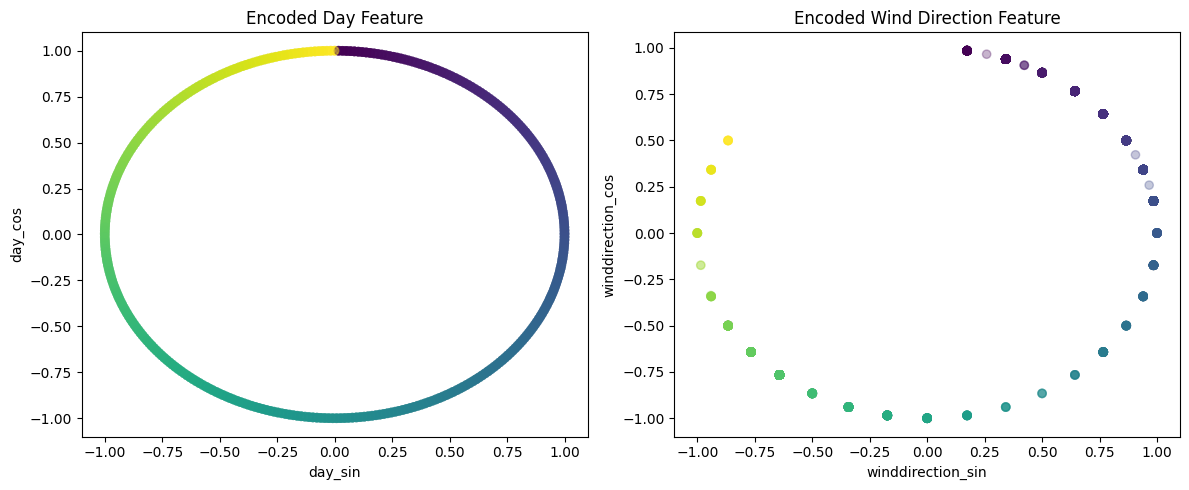

In [50]:
# Define a function to encode cyclical features
def encode_cyclical_features(df, feature, period):
    df_encoded = df.copy()
    df_encoded[f'{feature}_sin'] = np.sin(2 * np.pi * df[feature] / period)
    df_encoded[f'{feature}_cos'] = np.cos(2 * np.pi * df[feature] / period)
    return df_encoded

# Encode day (1-365)
train_processed = encode_cyclical_features(train_processed, 'day', 365)
test_processed = encode_cyclical_features(test_processed, 'day', 365)

# Encode winddirection (0-360)
train_processed = encode_cyclical_features(train_processed, 'winddirection', 360)
test_processed = encode_cyclical_features(test_processed, 'winddirection', 360)

# Visualize the encoded cyclical features
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(train_processed['day_sin'], train_processed['day_cos'], alpha=0.3, c=train_processed['day'])
plt.title('Encoded Day Feature')
plt.xlabel('day_sin')
plt.ylabel('day_cos')

plt.subplot(1, 2, 2)
plt.scatter(train_processed['winddirection_sin'], train_processed['winddirection_cos'], alpha=0.3, c=train_processed['winddirection'])
plt.title('Encoded Wind Direction Feature')
plt.xlabel('winddirection_sin')
plt.ylabel('winddirection_cos')

plt.tight_layout()
plt.show()

# Remove original cyclical features after encoding
train_processed = train_processed.drop(['day', 'winddirection'], axis=1)
test_processed = test_processed.drop(['day', 'winddirection'], axis=1)


 ### 3.2 Handle Skewed Distributions



 Several features showed skewed distributions in our EDA. We'll apply appropriate transformations to address this.

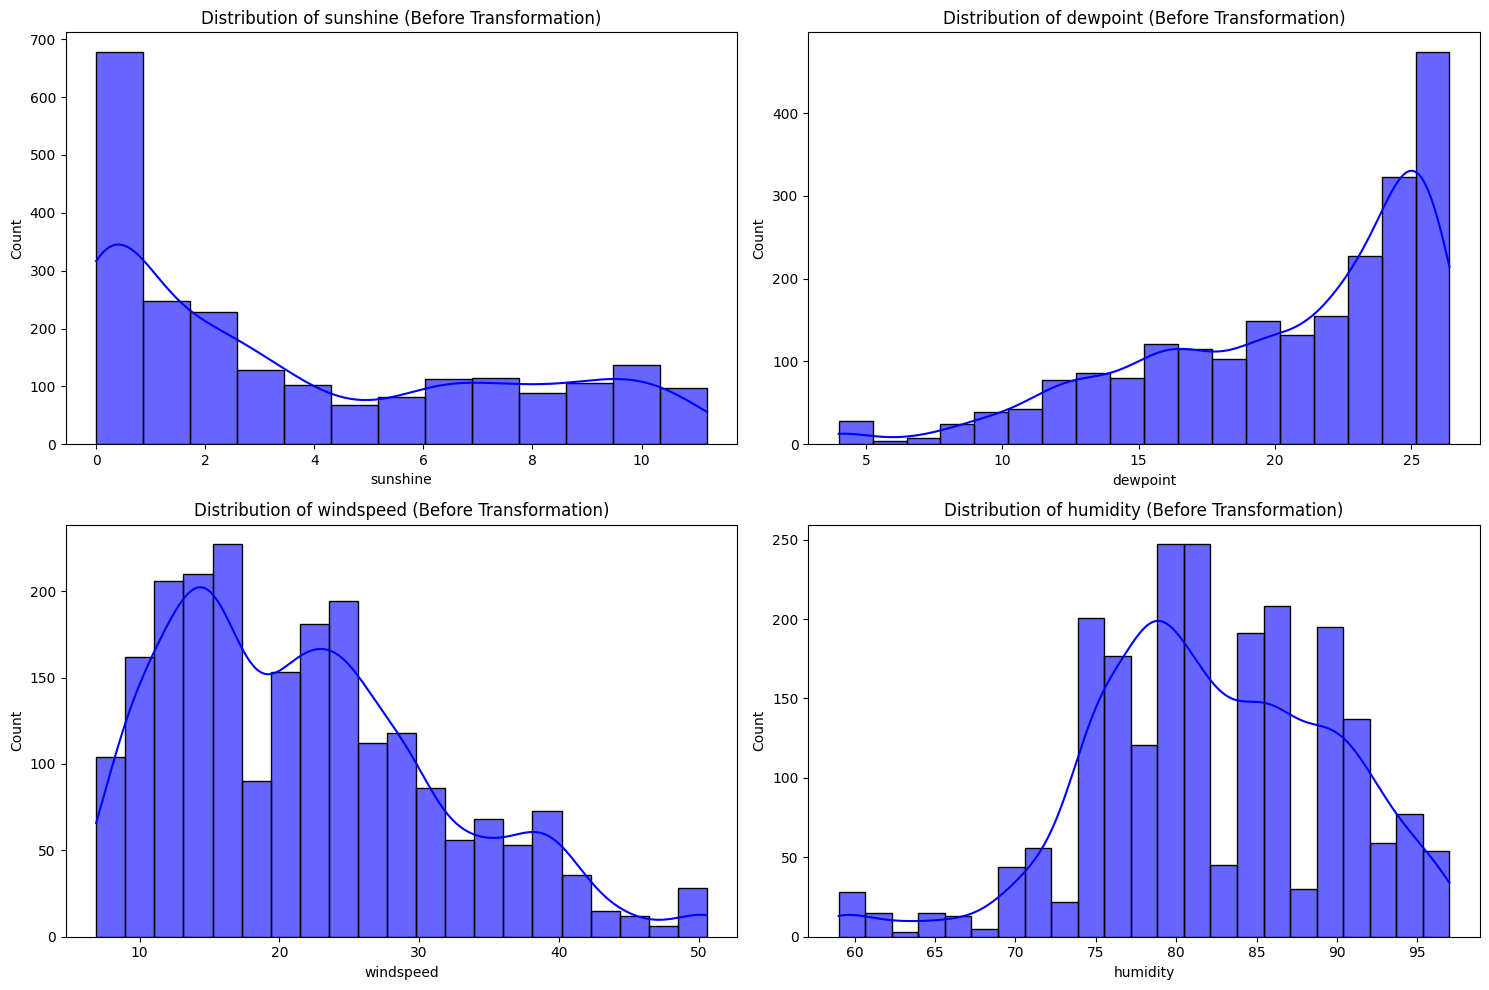

In [51]:
# Plot the distribution of skewed features before transformation
skewed_features = ['sunshine', 'dewpoint', 'windspeed', 'humidity']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(skewed_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(train_processed[feature], kde=True, color='blue', alpha=0.6)
    plt.title(f"Distribution of {feature} (Before Transformation)")
plt.tight_layout()
plt.show()


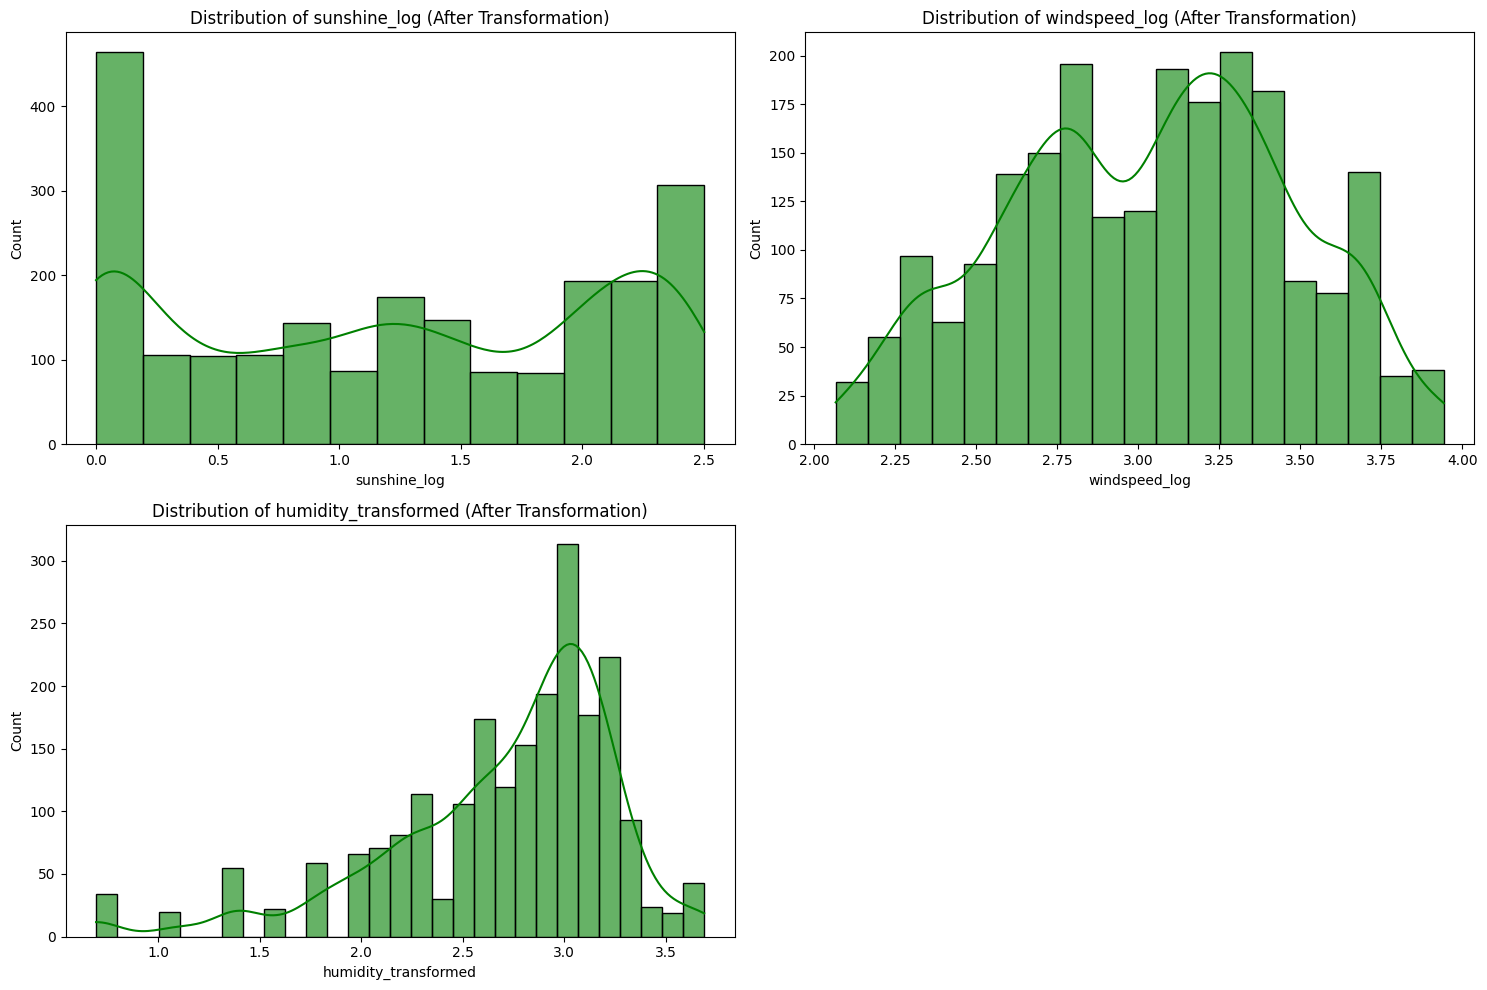

In [52]:
# Apply log transformation to right-skewed features
# Add a small constant to avoid log(0) issues
train_processed['sunshine_log'] = np.log1p(train_processed['sunshine'])
test_processed['sunshine_log'] = np.log1p(test_processed['sunshine'])

train_processed['windspeed_log'] = np.log1p(train_processed['windspeed'])
test_processed['windspeed_log'] = np.log1p(test_processed['windspeed'])

# For left-skewed humidity, apply reflection and log transformation
max_humidity = max(train_processed['humidity'].max(), test_processed['humidity'].max()) + 1
train_processed['humidity_transformed'] = np.log1p(max_humidity - train_processed['humidity'])
test_processed['humidity_transformed'] = np.log1p(max_humidity - test_processed['humidity'])

# Plot distributions after transformation
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(train_processed['sunshine_log'], kde=True, color='green', alpha=0.6)
plt.title("Distribution of sunshine_log (After Transformation)")

plt.subplot(2, 2, 2)
sns.histplot(train_processed['windspeed_log'], kde=True, color='green', alpha=0.6)
plt.title("Distribution of windspeed_log (After Transformation)")

plt.subplot(2, 2, 3)
sns.histplot(train_processed['humidity_transformed'], kde=True, color='green', alpha=0.6)
plt.title("Distribution of humidity_transformed (After Transformation)")

plt.tight_layout()
plt.show()

# Remove the original skewed features
train_processed = train_processed.drop(['sunshine', 'windspeed', 'humidity'], axis=1)
test_processed = test_processed.drop(['sunshine', 'windspeed', 'humidity'], axis=1)


 ### 3.3 Create Interaction Features



 Based on the EDA, we observed relationships between certain features. Let's create some interaction features.

In [53]:
# Create temperature range feature
train_processed['temp_range'] = train_processed['maxtemp'] - train_processed['mintemp']
test_processed['temp_range'] = test_processed['maxtemp'] - test_processed['mintemp']

# Create dewpoint depression (difference between temperature and dewpoint)
train_processed['dewpoint_depression'] = train_processed['temparature'] - train_processed['dewpoint']
test_processed['dewpoint_depression'] = test_processed['temparature'] - test_processed['dewpoint']

# Create cloud x sunshine_log interaction
train_processed['cloud_sunshine_interaction'] = train_processed['cloud'] * train_processed['sunshine_log']
test_processed['cloud_sunshine_interaction'] = test_processed['cloud'] * test_processed['sunshine_log']

# Create pressure x temperature interaction
train_processed['pressure_temp_interaction'] = train_processed['pressure'] * train_processed['temparature']
test_processed['pressure_temp_interaction'] = test_processed['pressure'] * test_processed['temparature']


 ### 3.4 Handle Multicollinearity



 From the correlation analysis, we observed high correlations among temperature-related features. Let's address this.

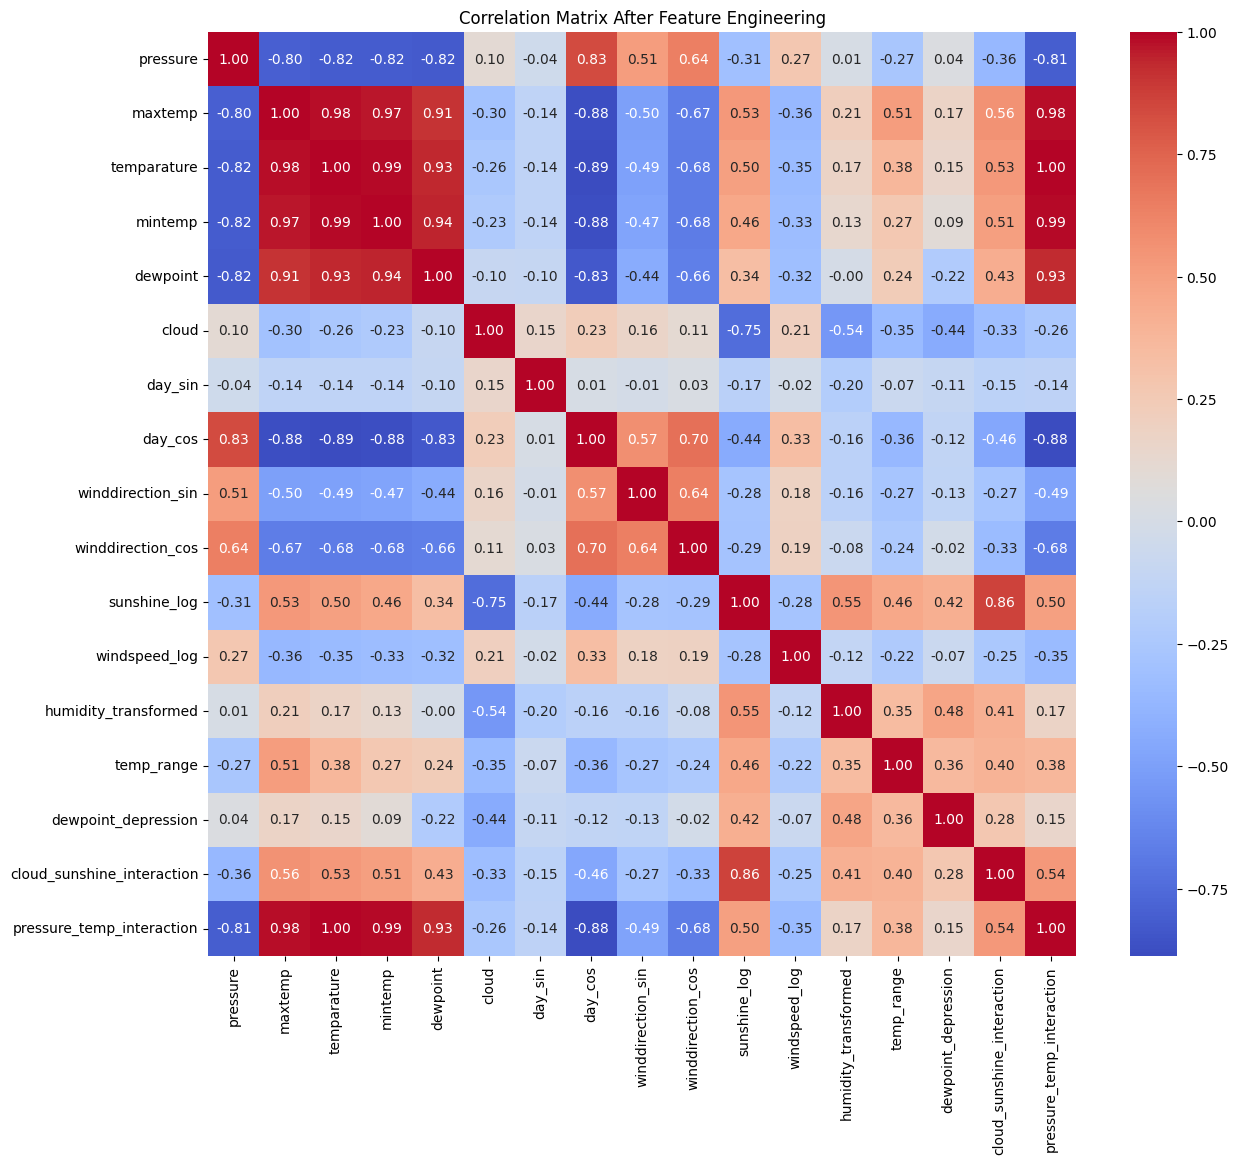

In [54]:
# Calculate correlation matrix for processed train data (excluding target)
corr_matrix = train_processed.drop('rainfall', axis=1).corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix After Feature Engineering')
plt.show()


In [55]:
# Identify highly correlated features
threshold = 0.85
high_corr_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            high_corr_features.append((colname_i, colname_j, corr_matrix.iloc[i, j]))

print("Highly correlated feature pairs:")
for feat1, feat2, corr in high_corr_features:
    print(f"{feat1} and {feat2}: {corr:.4f}")


Highly correlated feature pairs:
temparature and maxtemp: 0.9833
mintemp and maxtemp: 0.9663
mintemp and temparature: 0.9876
dewpoint and maxtemp: 0.9075
dewpoint and temparature: 0.9339
dewpoint and mintemp: 0.9430
day_cos and maxtemp: -0.8790
day_cos and temparature: -0.8871
day_cos and mintemp: -0.8762
cloud_sunshine_interaction and sunshine_log: 0.8622
pressure_temp_interaction and maxtemp: 0.9831
pressure_temp_interaction and temparature: 0.9999
pressure_temp_interaction and mintemp: 0.9874
pressure_temp_interaction and dewpoint: 0.9330
pressure_temp_interaction and day_cos: -0.8834


In [56]:
# Handle multicollinearity by keeping only one feature from highly correlated pairs
# We'll keep features that have stronger correlation with the target or better interpretability

# Check correlation with target
target_corr = train_processed.corr()['rainfall'].sort_values(ascending=False)
print("\nFeature correlation with target (rainfall):")
print(target_corr)

# Features to drop based on correlation analysis (keeping the more informative one from each pair)
features_to_drop = ['temparature', 'mintemp']  # These have high correlation with maxtemp

train_processed = train_processed.drop(features_to_drop, axis=1)
test_processed = test_processed.drop(features_to_drop, axis=1)

print(f"\nRemaining features after handling multicollinearity: {train_processed.columns.tolist()}")



Feature correlation with target (rainfall):
rainfall                      1.000000
cloud                         0.641937
windspeed_log                 0.129368
dewpoint                      0.080242
day_sin                       0.075008
winddirection_sin             0.062394
day_cos                       0.047951
winddirection_cos            -0.014084
mintemp                      -0.029175
pressure                     -0.049486
temparature                  -0.052843
pressure_temp_interaction    -0.054384
maxtemp                      -0.081299
temp_range                   -0.206463
cloud_sunshine_interaction   -0.218465
dewpoint_depression          -0.366252
humidity_transformed         -0.395569
sunshine_log                 -0.494520
Name: rainfall, dtype: float64

Remaining features after handling multicollinearity: ['pressure', 'maxtemp', 'dewpoint', 'cloud', 'rainfall', 'day_sin', 'day_cos', 'winddirection_sin', 'winddirection_cos', 'sunshine_log', 'windspeed_log', 'humidity_tran

 ### 3.5 Handle Bimodal Distributions



 Some features like pressure, maxtemp, and cloud exhibited bimodal distributions in the EDA.

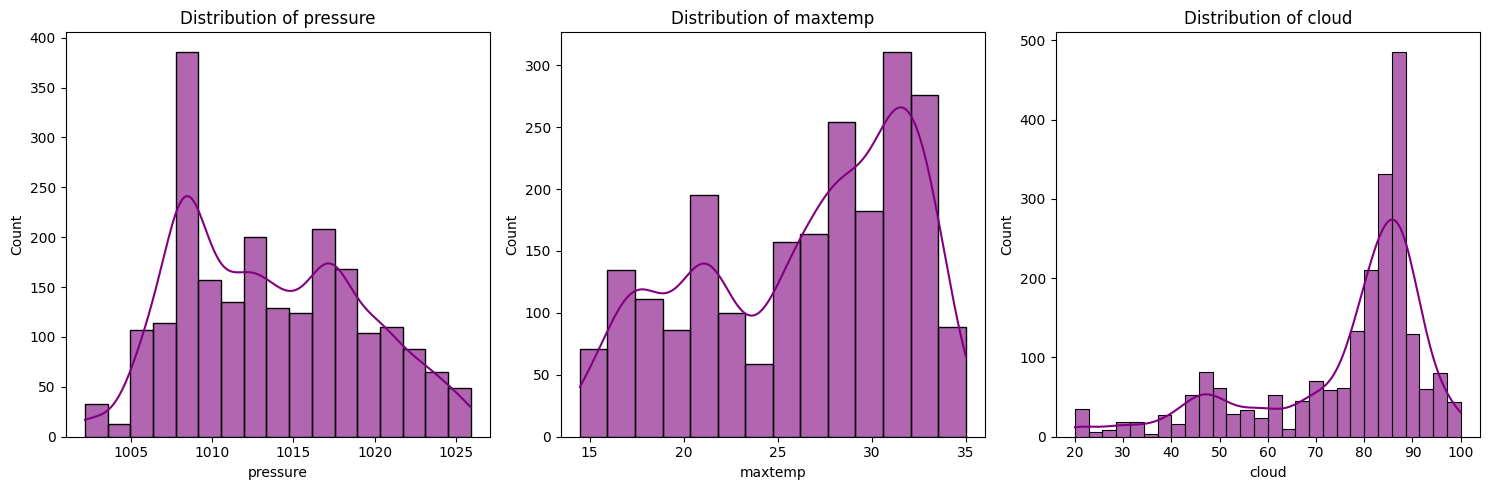

In [57]:
# Visualize bimodal distributions
bimodal_features = ['pressure', 'maxtemp', 'cloud']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(bimodal_features):
    if feature in train_processed.columns:  # Check if feature is still present
        plt.subplot(1, 3, i+1)
        sns.histplot(train_processed[feature], kde=True, color='purple', alpha=0.6)
        plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()


In [58]:
# Create binary indicators for bimodal features
# For each feature, create a binary indicator based on a threshold

# Define thresholds based on the observed distributions
pressure_threshold = train_processed['pressure'].median()
cloud_threshold = train_processed['cloud'].median()
maxtemp_threshold = train_processed['maxtemp'].median()

# Create binary features
train_processed['pressure_high'] = (train_processed['pressure'] > pressure_threshold).astype(int)
test_processed['pressure_high'] = (test_processed['pressure'] > pressure_threshold).astype(int)

train_processed['cloud_high'] = (train_processed['cloud'] > cloud_threshold).astype(int)
test_processed['cloud_high'] = (test_processed['cloud'] > cloud_threshold).astype(int)

train_processed['maxtemp_high'] = (train_processed['maxtemp'] > maxtemp_threshold).astype(int)
test_processed['maxtemp_high'] = (test_processed['maxtemp'] > maxtemp_threshold).astype(int)


 ### 3.6 Feature Scaling



 Scale numerical features for models that are sensitive to feature scales.

In [59]:
# Identify numerical features for scaling (all except binary features and target)
binary_features = ['pressure_high', 'cloud_high', 'maxtemp_high']
target = ['rainfall']
features_to_scale = [col for col in train_processed.columns if col not in binary_features + target]

print("Features to scale:")
print(features_to_scale)


Features to scale:
['pressure', 'maxtemp', 'dewpoint', 'cloud', 'day_sin', 'day_cos', 'winddirection_sin', 'winddirection_cos', 'sunshine_log', 'windspeed_log', 'humidity_transformed', 'temp_range', 'dewpoint_depression', 'cloud_sunshine_interaction', 'pressure_temp_interaction']


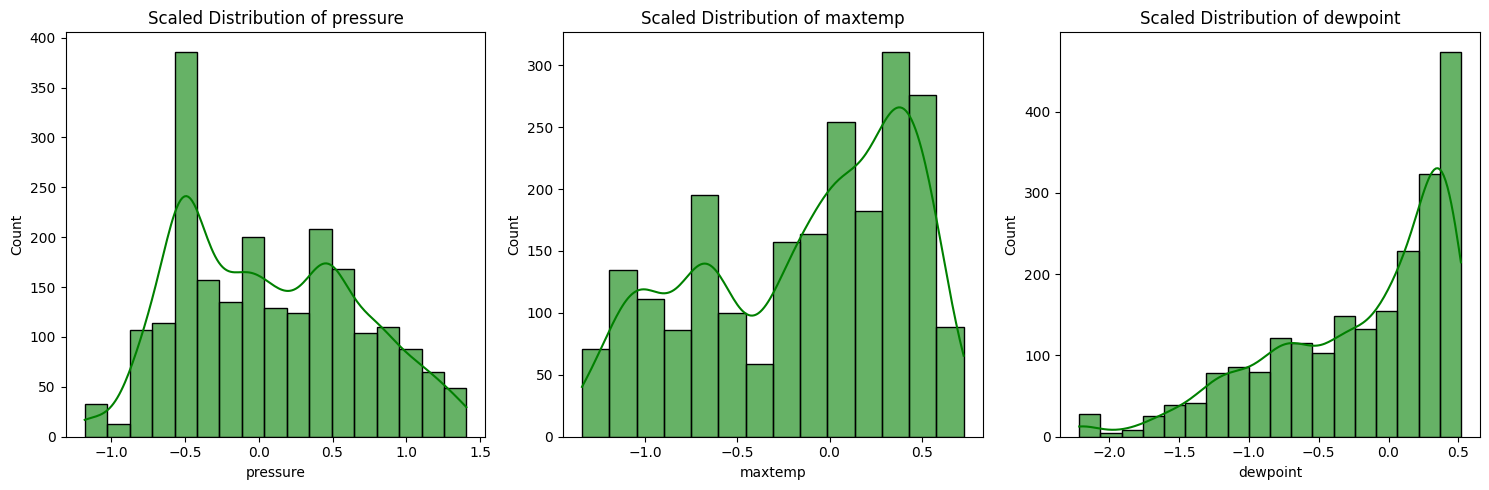

In [60]:
# Apply RobustScaler since we've already handled outliers but want to be robust to any remaining ones
scaler = RobustScaler()

# Fit scaler on train data
scaler.fit(train_processed[features_to_scale])

# Transform train and test data
train_processed[features_to_scale] = scaler.transform(train_processed[features_to_scale])
test_processed[features_to_scale] = scaler.transform(test_processed[features_to_scale])

# Visualize scaled features
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features_to_scale[:3]):  # Just plot first 3 for clarity
    plt.subplot(1, 3, i+1)
    sns.histplot(train_processed[feature], kde=True, color='green', alpha=0.6)
    plt.title(f"Scaled Distribution of {feature}")
plt.tight_layout()
plt.show()


 ## 4. Final Preprocessing Pipeline Summary

In [61]:
# Display the final processed datasets
print(f"Final processed train shape: {train_processed.shape}")
print(f"Final processed test shape: {test_processed.shape}")

print("\nFinal train columns:")
print(train_processed.columns.tolist())

print("\nTrain data sample after preprocessing:")
train_processed.head()


Final processed train shape: (2190, 19)
Final processed test shape: (730, 18)

Final train columns:
['pressure', 'maxtemp', 'dewpoint', 'cloud', 'rainfall', 'day_sin', 'day_cos', 'winddirection_sin', 'winddirection_cos', 'sunshine_log', 'windspeed_log', 'humidity_transformed', 'temp_range', 'dewpoint_depression', 'cloud_sunshine_interaction', 'pressure_temp_interaction', 'pressure_high', 'cloud_high', 'maxtemp_high']

Train data sample after preprocessing:


,pressure,maxtemp,dewpoint,cloud,rainfall,day_sin,day_cos,winddirection_sin,winddirection_cos,sunshine_log,windspeed_log,humidity_transformed,temp_range,dewpoint_depression,cloud_sunshine_interaction,pressure_temp_interaction,pressure_high,cloud_high,maxtemp_high
0,0.479564,-0.666667,-0.335366,0.263158,1,-0.015180,0.717684,0.184793,0.112135,-0.280521,-0.257347,-0.502500,-1.380952,-0.884211,-0.276456,-0.544435,1,1,0
1,0.708447,-1.171717,-0.823171,0.421053,1,-0.003035,0.717369,0.102030,0.213487,-0.712470,0.097427,-2.087463,-1.809524,-0.757895,-0.980640,-0.962132,1,1,0
2,1.209809,-0.848485,-1.567073,-1.894737,1,0.009103,0.716844,0.245773,0.000000,0.585823,-0.182803,0.497500,0.285714,1.473684,0.149785,-1.045196,1,0,0
3,0.043597,-0.979798,-0.652439,0.631579,1,0.021229,0.716109,0.184793,0.112135,-0.712470,0.821619,-2.087463,-1.428571,-0.968421,-0.980640,-0.871514,1,1,0
4,0.959128,-0.656566,-1.530488,-2.000000,0,0.033342,0.715165,0.000000,0.300976,0.175985,0.281579,1.234465,0.904762,2.315789,-0.239979,-0.786090,1,0,0


 ## 5. Preprocessing Steps Summary



 Here's a summary of all the preprocessing and feature engineering steps we've applied:



 1. **Basic Preprocessing**:

    - Handled missing values in the test dataset

    - Removed unnecessary 'id' column



 2. **Outlier Handling**:

    - Detected outliers using Isolation Forest

    - Capped extreme values at 1st and 99th percentiles



 3. **Feature Engineering**:

    - Encoded cyclical features ('day' and 'winddirection') using sine and cosine transformations

    - Applied log transformations to skewed features ('sunshine', 'windspeed')

    - Applied reflection and log transformation to left-skewed 'humidity'

    - Created interaction features ('temp_range', 'dewpoint_depression', 'cloud_sunshine_interaction', 'pressure_temp_interaction')

    - Added binary indicators for bimodal distributions ('pressure_high', 'cloud_high', 'maxtemp_high')



 4. **Multicollinearity Handling**:

    - Identified highly correlated features

    - Removed redundant features while keeping the most informative ones



 5. **Feature Scaling**:

    - Applied RobustScaler to numerical features for models sensitive to feature scales



 The resulting preprocessed datasets are ready for model training and evaluation.

 ## 6. Save Processed Datasets

In [62]:
# Save processed datasets to CSV files
train_processed.to_csv('data/train_processed.csv', index=False)
test_processed.to_csv('data/test_processed.csv', index=False)

print("Processed datasets saved successfully.")

Processed datasets saved successfully.
